# Aster Centering Analysis - Day 2
***
<i> Dmitrief, Turlier, De Labbey, Badaoui </i> </br>
<i> ENS - Active Matter  Workshop - Feb 22 </i>

In this notebook, we use Cytosim Analysis to analyze a Simulation where an Aster autonomously moves to the center.

## Imports

In [48]:
#Add stuff to path

from pathlib import Path
sys.path.insert(0,str(Path().absolute()) + '/cytosim_analysis/')


#Classic Import

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl
import pandas as pd
import sys
import os 

#Cytolysis Import

from src.objects import Object, Object_set
import src.cytosim_analysis as ana
import sio_tools as sio


from aster import Aster_set
from tweezer import read_space
from methods import distance, colin, total_force, total_individual_forces, tweezer_distance


In [50]:
#PARAMETERS

frame_step = 0.1

#PATH

current_path = str(Path().absolute()) 
path_simu = current_path  + '/simu'

## <u> Vesicule Pulling </u>

Here, we would like to investigate an other possible mechanism based on pulling.  

For this example, we deal with motors which can bind both to cytoplasmic vesicules and microtubules. Thus, by linking them, they can generate forces which could center the system.

### <i> <u> First Part - Position </u> </i>
<i>First We will check the Position of The Aster</i>.

**Q1. Run the simulation with the config file in `example_pulling` by using the `sim` command.**

**Q2. Report the characteristic of the Aster with the `report` command applied to:**

* `aster:links > links.txt`
* `aster:force > force.txt`

**Q3. Check the files consistency and use the `cytosim_analysis` package to analyze the report files.**

*NB : You should get a Pandas DataFrame summarizing all the important quantitites.*

In [14]:
##CHOOSE YOUR FOLDER - EXAMPLE, EXAMPLE CENETERING PUSHING, VESICULE PULLING OR CORTICAL PULLING FOLDER
# PUT IT IN METHODS

def cytosim_analysis_function(path_in):
    

    # REPORT FILES

    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in + "/links.txt" #Links for the Aster

    #Config
    config_file = path_in + "/config.cym" #Config File

    # DICTIONNARY

    #Solid
    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    # CREATE SIMULATION INSTANCE

    simul = ana.Simulation(solid_report={"core": solids},
                           solid_options=solid_opts,
                           config=config_file, dim=2)

    # ANALYSIS FUNCTION DECLARATION

    analyzer={"distance": distance, 
              "colin": colin , 
              "total_force":total_force, 
              "total_individual_forces":total_individual_forces} 

    # ANALYSIS

    simul.make_analysis(frame_analyzer=analyzer)
    analysis=simul.frames_analysis
    
    return analysis


In [17]:
folder_test = '/example_pulling'

df_analysis = cytosim_analysis_function(path_simu + folder_test)
df_analysis
distance_aster = df_analysis['distance']

/home/magid/Desktop/ENS_Workshop_Cytosim/cytosim-aster-course/methods.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(pos,force)/(npl.norm(pos)*npl.norm(force))


**Q4. Is the Aster Centering ?**
* **A. Plot the distance to the center with respect to the time and check the stability of it.**
* **B. You can help yourself with the `play` command on Cytosim.**

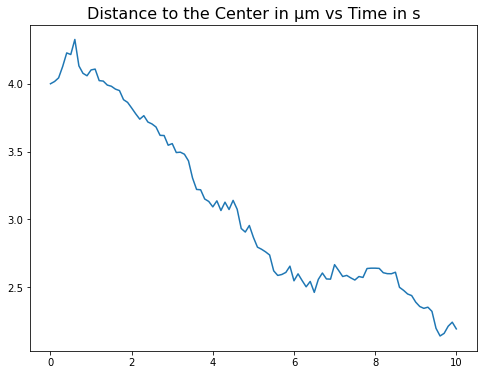

In [18]:
#PLOTS

#Centration of The Aster

plt.figure(figsize =(8,6))

plt.plot(df_analysis["id"]*frame_step,distance_aster,label="Distance to the Center")

plt.title('Distance to the Center in µm vs Time in s',size =16)
plt.show()

**C. If it is not centering, what do you suggest to permit it ?**

* Increase the number of motors ?

You can tweak the parameters on the `example_pulling_centering` file and restart !


### <i> <u> Second Part - Force - Tweezer </u></i>
<i>One way to quantify te stability of the Aster Positionning is to measure the force with respect to the position, to conclude whether or not the position is a stable fixed point.
</i>

To do so, we will use configuration templates and work in the `pulling_tweezers` directory with template `config_tpl.cym`:

Here we are directly going to play with the Tweezers to preciseley probe the Force-Position relationshop for an Aster centering thanks to vesicule pulling.

``` 
[[ i_position = range(19) ]]
[[ x = -9 + i_position ]] 
% assign [[x]]

new tweezer
{
    center = ( [[x]] 0 )
}
```

**Q9. Just like yesterday, follow these steps to generate config files, run simulations and report stuff**  

* Generate config files

  `preconfig.py config_tpl.cym`
  

* Place in separated directories

  `mkdir files`  
  `mv config_tpl*.cym ./files`
  
  
* Run simulations

  `go_sim.py sim ./file/config_tpl*.cym njobs=10`
  
  
* Report stuff

 `scan.py 'report aster:force > force.txt' run0* njobs=10 `  
 `scan.py 'report aster:links > links.txt' run0* njobs=10 `  
 `scan.py 'report space:tweezer > tweezers.txt' run0* njobs=10 `

In [ ]:
def cytosim_analysis_function_tweezers(path_in):
    
    # REPORT FILES

    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in  + "/links.txt" #Links for the Aster

    #Tweezer
    space_file = path_in + "/tweezers.txt" #Optical Tweezer Properties
    
    #Config
    config_file = path_in + "/config.cym" #Config File

    ## A PASSER DANS METHODS

    def read_space(space_set, reports=None):

            if reports is not None:
                keys = reports.keys()
                if 'space' in keys:
                    #this is too long yes...
                    with open(space_file) as f:
                        lines = [line.split() for line in f if (line[0] != '%')]
                        lines = [line for line in lines if (len(line)!= 0)]
                        lines = [line for line in lines if line[0] != 'tweezer']
                        lines = np.resize(lines,(len(lines)//3,3))

                    for row in lines:
                        space_set.append(Object(position=row[0]))
    # DICTIONNARY

    #Solid
    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    #Space
    spaces = {"space": space_file}
    space_opts = {"read": read_space}
    
    # RUN SIMUL
    
    simul = ana.Simulation(space_report = {"tweezer":spaces},
                           space_options = space_opts, 
                           solid_report={"core": solids},
                           solid_options=solid_opts,
                           config=config_file, dim=2)
    
    # ANALYSIS FUNCTION DECLARATION

    analyzer={"distance": distance, 
              "colin": colin , 
              "total_force":total_force,
              "tweezer_distance":tweezer_distance}
    
    # ANALYSIS
    
    simul.make_analysis(frame_analyzer=analyzer)
    
    analysis=simul.frames_analysis
    
    return analysis 


In [ ]:
#Analyzing Loop

assigned_tweezer = [ -9 + i for i in range(19)]

analysis_list = []

path_pulling = path_simu + '/pulling_tweezers/'

runs = np.sort(os.listdir(path_pushing))[1:]

for run in runs:
    print(run)
    analysis_list.append(cytosim_analysis_function_tweezers(path_pulling + run))

### <i> <u> Third Part - Vesicule Pulling - Force vs Position </u> </i>

Thanks to the Tweezers we can get the force vs position curve.